In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
initial_path = 'peptide-QML/'
initial_path = '../'

In [37]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import pytorch_model as ptm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
dim = 4

# type_network = 'c'
type_network = 'h'

energies = ''
# energies = '_Single'
# energies = '_Pair'

# version = '_v2'
version = ''

In [39]:
name_notebook = '0901-{}{}_em_1qm{}{}'.format(dim, type_network, energies, version) 

In [40]:
name_notebook = '0901-8h_em_1qm'

In [41]:
# return last line of the file
def read_version(name_notebook):
    day = name_notebook.split('-')[0]
    file = open(initial_path + "checkpoints/" + day + "/versions/" + name_notebook + ".version", "r")
    version = int(file.readlines()[-1])
    return version


In [42]:
version = read_version(name_notebook)

losses = []
n_qubits = []
n_layers = []

for i in range(1, version + 1):
    day = name_notebook.split('-')[0]

    # load trained model  
    file_path = initial_path + "checkpoints/" + day + "/pickled_objects/" + name_notebook + "_" + str(i)+  ".pickle"
    try: 
        model = ptm.pytorch_model.load(file_path)
    except:
        print("File not found: " + file_path)
        continue
    
    
    # loss
    loss = min(model.losses_epochs)

    # number of layers and qubits
    if type_network == 'c':
        layers = len(str(model).split('Linear(in_features={}, out_features={}, bias=True)'.format(dim, dim))) - 1
        qubits = None
    else:
        file_path = initial_path + "checkpoints/" + day + "/txts/" + name_notebook + "_model_str_" + str(i) + ".txt"
        lines = [line.replace('\t', '').replace('\n', '') for line in open(file_path, "r").readlines()]
        layers = int([line for line in lines if 'block_n_layers' in line][0].split(' ')[-1])
        qubits = int([line for line in lines if 'n_qubits' in line][0].split(' ')[-1])

    # append data
    losses.append(loss)
    n_qubits.append(qubits)
    n_layers.append(layers)


d:\Raul\Programs\envs\PennyLane\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[10.30145182  9.56811471 11.38897805 10.55877846]


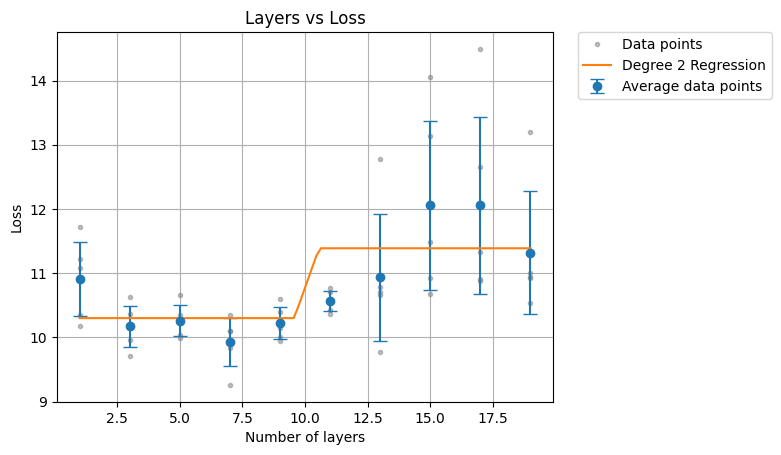

In [43]:
import numpy as np
from scipy.optimize import curve_fit

def piecewise_function(x, a, b, c, d):
    y = np.zeros_like(x)

    y[x < b] = a
    y[(x >= b) & (x < d)] = x[(x >= b) & (x < d)] * (a - c) / (b - d + 0.000000001) + (b * c - a * d) / (b - d + 0.000000001)
    y[x >= d] = c

    return y

# Given data
y = np.array(losses)
x = np.array(n_layers)

# Order the data by x values
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

# Average the loss for the same number of layers
x_avg = np.array(list(set(x)))
y_avg = np.array([np.mean(y[x == xi]) for xi in x_avg])
y_std = np.array([np.std(y[x == xi]) for xi in x_avg])  # Standard deviation for error bars

# Polynomial Regression data
degree = 2

params, covariance = curve_fit(piecewise_function, x_avg, y_avg, p0=(7.5, 8, 25, 10))
print(params)
x_pred = np.linspace(x.min(), x.max(), 100)
y_pred = piecewise_function(x_pred, *params)

# Plot
plt.plot(x, y, 'o', label="Data points", alpha=0.5, color='grey', markersize=3)        # Data points
plt.errorbar(x_avg, y_avg, yerr=y_std, fmt='o', label="Average data points", capsize=5)  # Data points with error bars
plt.plot(x_pred, y_pred, '-', label="Degree {} Regression".format(degree))  # Regression line
plt.xlabel('Number of layers')
plt.ylabel('Loss')
# plt.title('Layers vs Loss ('+ str(n_qubits[0]) + ' qubits)')
plt.title('Layers vs Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()

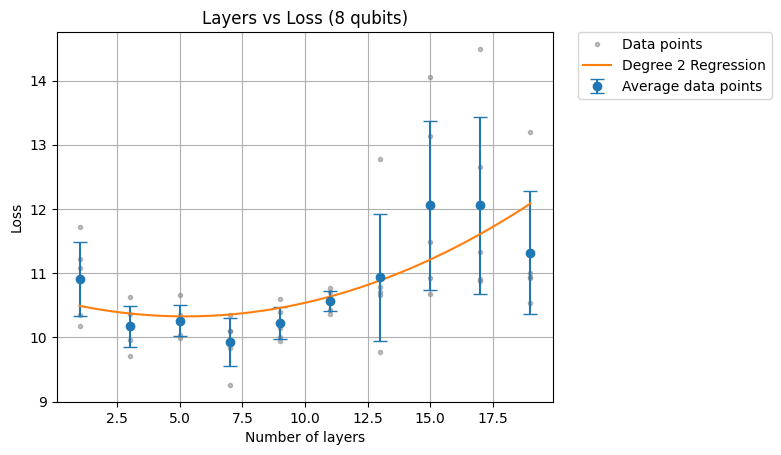

In [44]:
# Given data
y = np.array(losses)
x = np.array(n_layers)

# Order the data by x values
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

# Average the loss for the same number of layers
x_avg = np.array(list(set(x)))
y_avg = np.array([np.mean(y[x == xi]) for xi in x_avg])
y_std = np.array([np.std(y[x == xi]) for xi in x_avg])  # Standard deviation for error bars

# Polynomial Regression data
degree = 2
coefficients = np.polyfit(x, y, degree)
x_pred = np.linspace(x.min(), x.max(), 100)
y_pred = np.polyval(coefficients, x_pred)

# Plot
plt.plot(x, y, 'o', label="Data points", alpha=0.5, color='grey', markersize=3)        # Data points
plt.errorbar(x_avg, y_avg, yerr=y_std, fmt='o', label="Average data points", capsize=5)  # Data points with error bars
plt.plot(x_pred, y_pred, '-', label="Degree {} Regression".format(degree))  # Regression line
plt.xlabel('Number of layers')
plt.ylabel('Loss')
plt.title('Layers vs Loss ('+ str(n_qubits[0]) + ' qubits)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()

